# First Experiment

In [22]:
import torch.nn as nn
import torch
from deepstruct.node_map_strategies import Linear2LayerMapper, Conv2LayerMapper
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
from deepstruct.model_graph_stats import get_model_graph_stats

In [14]:
class FC_1000(nn.Module):
    
    def __init__(self):
        super(FC_1000, self).__init__()
        self.fc = nn.Linear(1000, 1000)
    
    def forward(self, x):
        return self.fc(x)
    
class FC_2000(nn.Module):
    
    def __init__(self):
        super(FC_2000, self).__init__()
        self.fc = nn.Linear(2000, 2000)
    
    def forward(self, x):
        return self.fc(x)
    
class Simple_Conv(nn.Module):

    def __init__(self):
        super(Simple_Conv, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1, padding=1)
        
    def forward(self, x):
        return self.conv(x)
    

In [15]:
fc_1000 = FC_1000()
fc_2000 = FC_2000()
simple_conv = Simple_Conv()

fc_1000_input = torch.randn(1, 1000) # Batch size of 1
fc_2000_input = torch.randn(1, 2000) # Batch size of 1

conv_input = torch.randn(1, 3, 64, 64) 
conv_input2 = torch.randn(1, 3, 84, 84)


In [60]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def effective_conv_operations(input_height, input_width, in_channel, output_channel, kernel_size, stride=1, padding=0):
    output_height = (input_height - kernel_size + 2 * padding) // stride + 1
    output_width = (input_width - kernel_size + 2 * padding) // stride + 1
    operations_per_output_element = kernel_size * kernel_size * in_channel
    total_conv_operations = operations_per_output_element * output_height * output_width * output_channel
    return total_conv_operations

print('fc_1000: ', count_parameters(fc_1000))
print('fc_2000: ', count_parameters(fc_2000))
print('simple_conv: ', count_parameters(simple_conv))
print('simple_conv ops: ', effective_conv_operations(64, 64, 3, 4, 5))
print('simple_conv ops 2: ', effective_conv_operations(84, 84, 3, 4, 5))

input_neurons_count = {'FC_1000': fc_1000_input.numel(), 'FC_2000': fc_2000_input.numel(),
                       'simple conv': conv_input.numel(), 'simple conv 2': conv_input2.numel()}

fc_1000:  1001000
fc_2000:  4002000
simple_conv:  304
simple_conv ops:  1080000
simple_conv ops 2:  1920000


In [ ]:
get_model_graph_stats(simple_conv, conv_input, 11, 'simple conv', 'simple_conv_low_level', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})

get_model_graph_stats(simple_conv, conv_input2, 11, 'simple conv 2', 'simple_conv_2_low_level', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})

get_model_graph_stats(fc_1000, fc_1000_input, 11, 'FC_1000', 'FC_1000_low_level', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})

get_model_graph_stats(fc_2000, fc_2000_input, 11, 'FC_2000', 'FC_2000_low_level', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})

## Correlation analysis with multiple Boxplots in one Chart
### X = model names
### Y = elapsed time in seconds

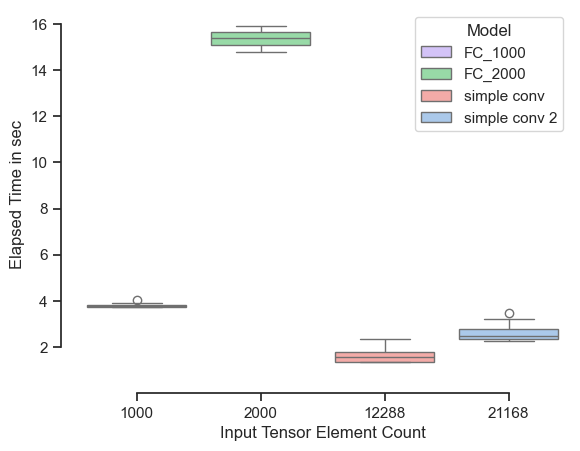

In [23]:
folder = "graph_stats/"
file_names = ["simple_conv_low_level.csv", "simple_conv_2_low_level.csv", "FC_1000_low_level.csv", "FC_2000_low_level.csv"]
dataframes = []
for file in file_names:
    df = pd.read_csv(folder + file)
    model_name = df.loc[1, 'Model']
    df['Input size'] = input_neurons_count[model_name]
    dataframes.append(df)

combined_df = pd.concat(dataframes)
sns.set_theme(style='ticks', palette='pastel')
sns.boxplot(x='Input size', y='Elapsed Time', data=combined_df, hue='Model', palette=['m', 'g', 'r', 'b'])
sns.despine(offset=10, trim=True)
# plt.legend = 'Input tensor elements'
plt.xlabel('Input Tensor Element Count')
plt.ylabel('Elapsed Time in sec')
plt.show() 


# Second Experiment

In [ ]:
input_tensor = torch.rand(1, 3, 224, 224)

get_model_graph_stats(torchvision.models.resnet152(True), input_tensor, 11, 'ResNet_152', 'resnet_152_high_level')

get_model_graph_stats(torchvision.models.googlenet(True), input_tensor, 11, 'GoogleNet', 'googlenet_high_level')     

get_model_graph_stats(torchvision.models.alexnet(True), input_tensor, 11, 'AlexNet', 'alexnet_high_level')

In [ ]:
get_model_graph_stats(simple_conv, conv_input, 11, 'simple conv', 'simple_conv_high_level')

get_model_graph_stats(fc_1000, fc_1000_input, 11, 'FC_1000', 'FC_1000_high_level')

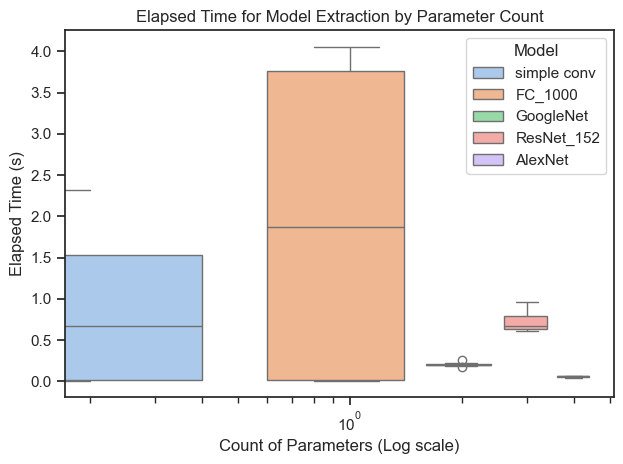

In [34]:
older = "graph_stats/"
file_names = ["simple_conv_low_level.csv", "simple_conv_high_level.csv", "FC_1000_high_level.csv",
              "FC_1000_low_level.csv", "alexnet_high_level.csv", "googlenet_high_level.csv", "resnet_152_high_level.csv"]
models = [simple_conv, simple_conv, fc_1000, fc_1000,
          torchvision.models.alexnet(True), torchvision.models.googlenet(True),
          torchvision.models.resnet152(True)]
final_df = pd.DataFrame()

for file, model in zip(file_names, models):
    df = pd.read_csv(folder + file)
    df['CountOfParameters'] = count_parameters(model)
    df['ExtractionLevel'] = 'High' if 'high' in file else 'Low'
    final_df = pd.concat([final_df, df])
    

#markers = {'AlexNet': 'o', 'ResNet_152': 's', 'GoogleNet': 'D', 'simple conv': '*', 'FC_1000': 'p'} 

#plt.figure(figsize=(10, 6))

sns.boxplot(x='CountOfParameters', y='Elapsed Time', data=final_df,
            hue='Model')

plt.title('Elapsed Time for Model Extraction by Parameter Count')
plt.xscale('log')
plt.xlabel('Count of Parameters (Log scale)')
plt.ylabel('Elapsed Time (s)')
# plt.legend(title='Model and Extraction Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
# TODO Das Diagramm drunter als Boxplots darstellen

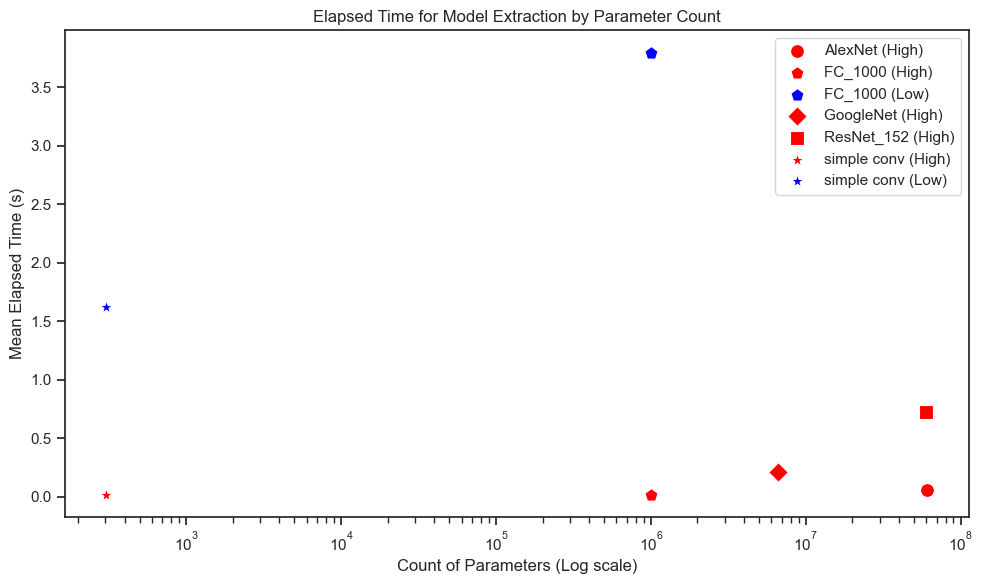

In [35]:
older = "graph_stats/"
file_names = ["simple_conv_low_level.csv", "simple_conv_high_level.csv", "FC_1000_high_level.csv",
              "FC_1000_low_level.csv", "alexnet_high_level.csv", "googlenet_high_level.csv", "resnet_152_high_level.csv"]
models = [simple_conv, simple_conv, fc_1000, fc_1000,
          torchvision.models.alexnet(True), torchvision.models.googlenet(True),
          torchvision.models.resnet152(True)]
final_df = pd.DataFrame(columns=['ModelName', 'ElapsedTime', 'CountOfParameters', 'ExtractionLevel'])

for file, model in zip(file_names, models):
    df = pd.read_csv(folder + file)
    data = [df['Model'][0], df['Elapsed Time'].mean(), count_parameters(model), 'High' if 'high' in file else 'Low']
    final_df.loc[len(final_df.index)] = data

markers = {'AlexNet': 'o', 'ResNet_152': 's', 'GoogleNet': 'D', 'simple conv': '*', 'FC_1000': 'p'} 
palette = {'Low': 'blue', 'High': 'red'} 

plt.figure(figsize=(10, 6))

for (modelName, extractionLevel), group_data in final_df.groupby(['ModelName', 'ExtractionLevel']):
    sns.scatterplot(x='CountOfParameters', y='ElapsedTime', data=group_data,
                    marker=markers[modelName], color=palette[extractionLevel], label=f'{modelName} ({extractionLevel})', s=100)

plt.title('Elapsed Time for Model Extraction by Parameter Count')
plt.xscale('log')
plt.xlabel('Count of Parameters (Log scale)')
plt.ylabel('Mean Elapsed Time (s)')
# plt.legend(title='Model and Extraction Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Experiment 3 - Structure Analysis

## Degree Distribution

In [37]:
graph_google_initial = get_model_graph_stats(torchvision.models.googlenet(), input_tensor, 1, 'GoogleNet', 'degreerank_experiment_google_net_initial')[0]

graph_google_pretrained = get_model_graph_stats(torchvision.models.googlenet(True), input_tensor, 1, 'GoogleNet', 'degreerank_experiment_google_net_pretrained')[0]

C:\Users\ericw\AppData\Local\pypoetry\Cache\virtualenvs\deepstruct-WwEyIJlS-py3.10\lib\site-packages\torchvision\models\googlenet.py:46: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Tracing Nodes: 100%|██████████| 212/212 [00:00<?, ?it/s]


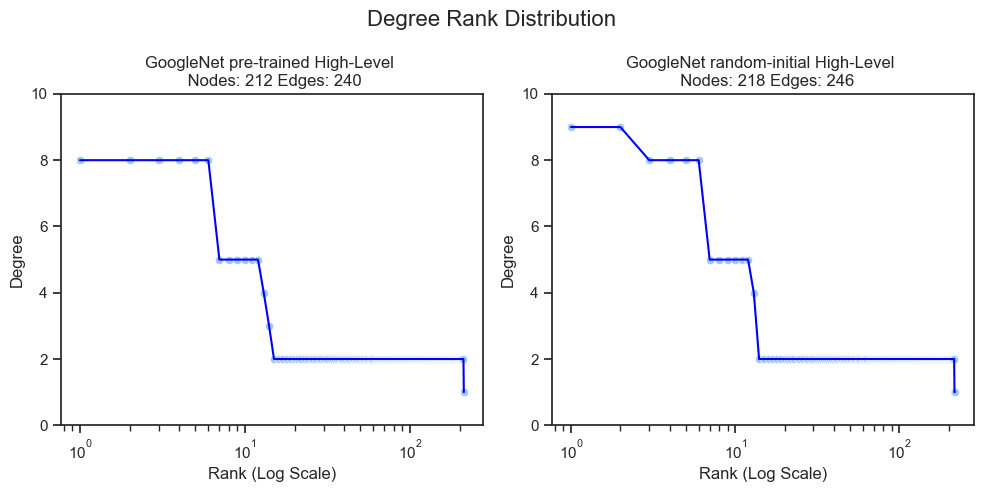

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# first plot
degrees = [degree for node, degree in graph_google_pretrained.degree()]
sorted_degrees = sorted(degrees, reverse=True)
ranks = np.arange(1, len(sorted_degrees) + 1)
data = pd.DataFrame({
    'Rank': ranks,
    'Degree': sorted_degrees
})

sns.scatterplot(data=data, x='Rank', y='Degree', ax=ax1)
ax1.plot(ranks, sorted_degrees, color='blue', label='Rank vs Degree')
ax1.set_xscale('log')
node_count_gg_pretrained = graph_google_pretrained.number_of_nodes()
edge_count_gg_pretrained = graph_google_pretrained.number_of_edges()
ax1.set_title('GoogleNet pre-trained High-Level \n Nodes: {} Edges: {}'.format(node_count_gg_pretrained, edge_count_gg_pretrained))
ax1.set_xlabel('Rank (Log Scale)')
ax1.set_ylabel('Degree')

# second plot
degrees = [degree for node, degree in graph_google_initial.degree()]
sorted_degrees = sorted(degrees, reverse=True)
ranks = np.arange(1, len(sorted_degrees) + 1)
data = pd.DataFrame({
    'Rank': ranks,
    'Degree': sorted_degrees
})

sns.scatterplot(data=data, x='Rank', y='Degree', ax=ax2)
ax2.plot(ranks, sorted_degrees, color='blue', label='Rank vs Degree')
ax2.set_xscale('log')
node_count_gg_initial = graph_google_initial.number_of_nodes()
edge_count_gg_initial = graph_google_initial.number_of_edges()

ax2.set_title('GoogleNet random-initial High-Level \n  Nodes: {} Edges: {}'.format(node_count_gg_initial, edge_count_gg_initial)) 
ax2.set_xlabel('Rank (Log Scale)')
ax2.set_ylabel('Degree')
ax1.set_ylim(0, 10)
ax2.set_ylim(0, 10)
fig.suptitle('Degree Rank Distribution', fontsize=16)
plt.tight_layout()
plt.show()

# Festgestellt dass beim Training zusätzlich etwas reingeladen wird wenn pretrained true ist, Argument für visuelle Darstellung um zu erkennen das etwas genauer angeschaut werden sollte 

Tracing Nodes: 100%|██████████| 3/3 [00:21<00:00,  7.24s/it]


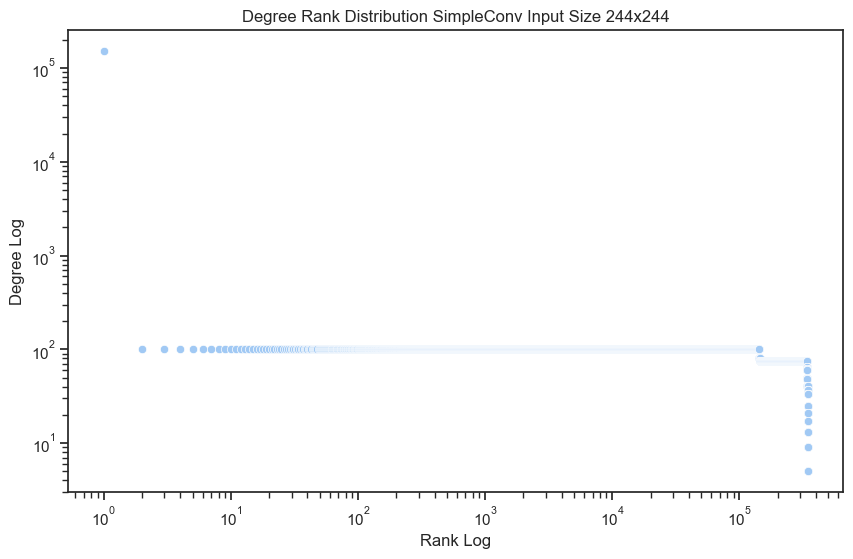

In [49]:
input_tensor = torch.rand(1, 3, 224, 224)
graph_low_level = get_model_graph_stats(simple_conv, input_tensor, 1, 'SimpleConv', 'degreerank_experiment_low_level', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})[0]

degrees = [degree for node, degree in graph_low_level.degree()]
sorted_degrees = sorted(degrees, reverse=True)
ranks = np.arange(1, len(sorted_degrees) + 1)
data = pd.DataFrame({
    'Rank': ranks,
    'Degree': sorted_degrees
})
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Rank', y='Degree')
# plt.plot(ranks, sorted_degrees, color='blue', label='Rank vs Degree')
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Rank Distribution SimpleConv Input Size 244x244')
plt.xlabel('Rank Log')
plt.ylabel('Degree Log')
plt.show()


Tracing Nodes: 100%|██████████| 3/3 [00:15<00:00,  5.31s/it]


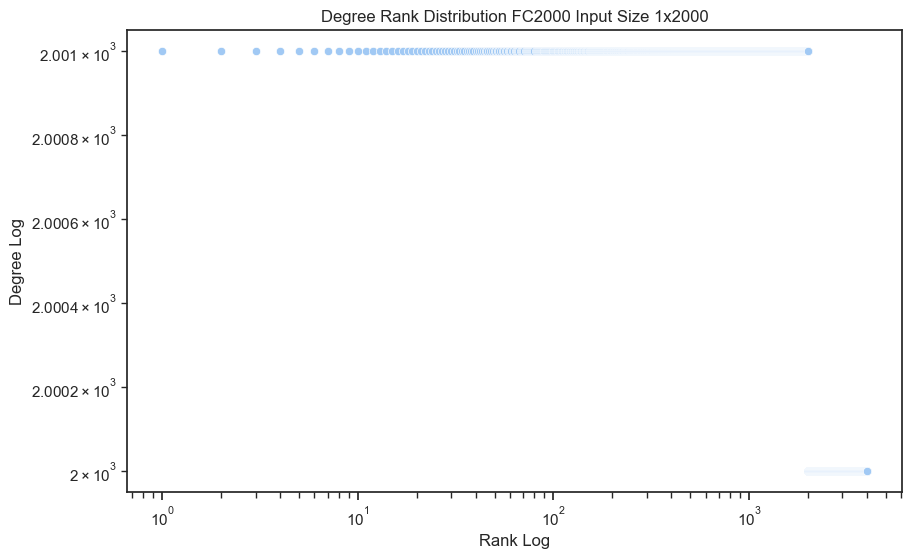

In [51]:
input_tensor = torch.randn(1, 2000)
graph_low_level = get_model_graph_stats(FC_2000(), input_tensor, 1, 'FC2000', 'degreerank_experiment_low_level_FC_2000', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})[0]

degrees = [degree for node, degree in graph_low_level.degree()]
sorted_degrees = sorted(degrees, reverse=True)
ranks = np.arange(1, len(sorted_degrees) + 1)
data = pd.DataFrame({
    'Rank': ranks,
    'Degree': sorted_degrees
})
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Rank', y='Degree')
# plt.plot(ranks, sorted_degrees, color='blue', label='Rank vs Degree')
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Rank Distribution FC2000 Input Size 1x2000')
plt.xlabel('Rank Log')
plt.ylabel('Degree Log')
plt.show()


## Avg. Path Length

In [62]:
input_tensor = torch.rand(1, 3, 224, 224)

models = [torchvision.models.resnet18(True),
          torchvision.models.densenet201(True),
          torchvision.models.mobilenet_v2(True),
          torchvision.models.alexnet(True), 
          torchvision.models.googlenet(True),
          torchvision.models.resnet152(True)]

names = ['ResNet18', 'DenseNet201', 'MobileNet_V2', 'AlexNet', 'GoogleNet', 'ResNet152']
df_avg_p = pd.DataFrame(columns=['ModelName', 'AvgPathLength', 'ParametersCount'])
for model, name in zip(models, names):
    g = get_model_graph_stats(model, input_tensor, 1, name, 'Temp')[0]
    df_avg_p.loc[len(df_avg_p.index)] = [name, nx.average_shortest_path_length(g), count_parameters(model)]

Tracing Nodes: 100%|██████████| 517/517 [00:00<00:00, 33009.93it/s]


C:\Users\ericw\AppData\Local\Temp\ipykernel_11660\1583340300.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 100000000)


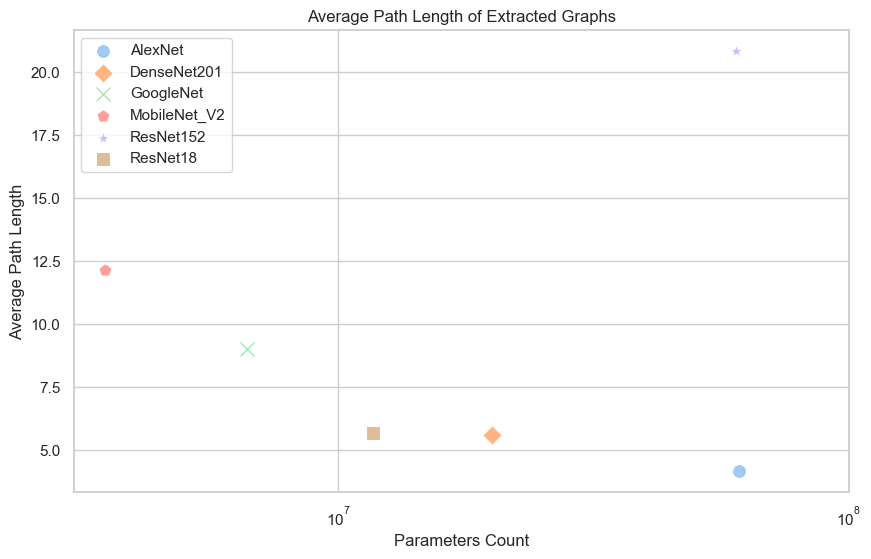

In [84]:
markers = {'AlexNet': 'o',
           'ResNet18': 's',
           'DenseNet201': 'D',
           'MobileNet_V2': 'p',
           'GoogleNet': 'x',
           'ResNet152': '*'}

plt.figure(figsize=(10, 6))

for (modelName, params_count), group_data in df_avg_p.groupby(['ModelName', 'ParametersCount']):
    sns.scatterplot(x='ParametersCount', y='AvgPathLength', data=group_data,
                    marker=markers[modelName], label=f'{modelName}', s=100)
plt.xscale('log')
plt.xlim(0, 100000000)
plt.title('Average Path Length of Extracted Graphs')
plt.xlabel('Parameters Count')
plt.ylabel('Average Path Length')

plt.show()


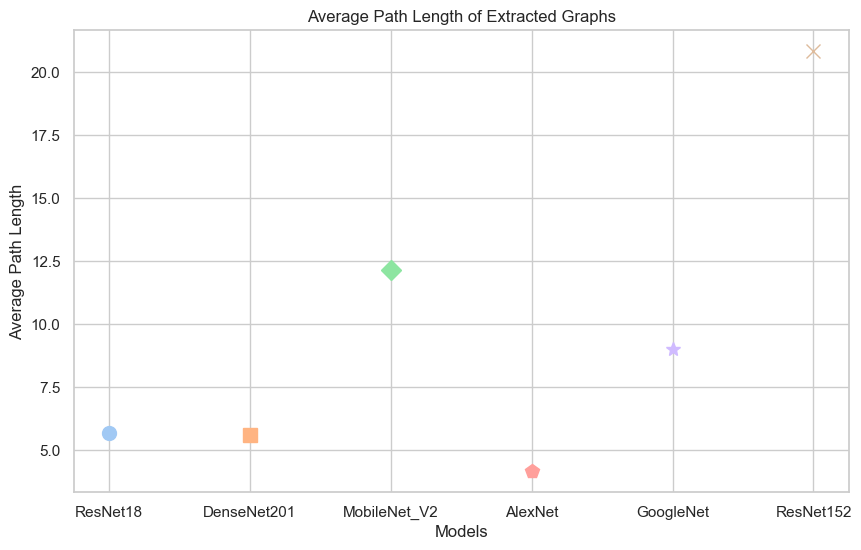

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

markers = ['o', 's', 'D', 'p', '*', 'x']
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
for i, row in df_avg_p.iterrows():
    plt.plot(row['ModelName'], row['AvgPathLength'], marker=markers[i], markersize=10, label=row['ModelName'])

# plt.legend(title='ModelName')
plt.title('Average Path Length of Extracted Graphs')
plt.xlabel('Models')
plt.ylabel('Average Path Length')

plt.show()
